# Random Forest Classifier -> `train_model_v3.ipynb`

Things to think about:
- Should I be adjusting the threshodl to find the best F1 score?
- See how XGBoost performs compared to Random Forest

## Import Packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


## Load extracted features CSV

In [3]:
df = pd.read_csv("../../data/combined_datasets/combined_3.csv")
# df = pd.read_csv("../../data/combined_datasets/foo.csv")

## Get Info 

In [4]:
df.head()

,ip.proto,frame.len,src_ip,dst_ip,c2_label,is_SYN,is_ACK,is_RST,is_FIN,is_PSH,is_URG,time_since_last,delta_t_ratio,rolling_mean_delta_t_3,rolling_std_delta_t_3,rolling_mean_delta_t_5,rolling_std_delta_t_5,rolling_mean_delta_t_10,rolling_std_delta_t_10
0,6,66,0,1,1,1,0,0,0,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,6,66,1,0,1,1,1,0,0,0,0,0.000438,1.000000,0.000219,0.000310,0.000219,0.000310,0.000219,0.000310
2,6,54,0,1,1,0,1,0,0,0,0,0.000038,0.086758,0.000159,0.000243,0.000159,0.000243,0.000159,0.000243
3,6,149,0,1,1,0,1,0,0,1,0,0.003427,90.184211,0.001301,0.001852,0.000976,0.001646,0.000976,0.001646
4,6,60,1,0,1,0,1,0,0,0,0,0.000317,0.092501,0.001261,0.001881,0.000844,0.001456,0.000844,0.001456


In [5]:
df.info()
df["c2_label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279184 entries, 0 to 279183
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ip.proto                 279184 non-null  int64  
 1   frame.len                279184 non-null  int64  
 2   src_ip                   279184 non-null  int64  
 3   dst_ip                   279184 non-null  int64  
 4   c2_label                 279184 non-null  int64  
 5   is_SYN                   279184 non-null  int64  
 6   is_ACK                   279184 non-null  int64  
 7   is_RST                   279184 non-null  int64  
 8   is_FIN                   279184 non-null  int64  
 9   is_PSH                   279184 non-null  int64  
 10  is_URG                   279184 non-null  int64  
 11  time_since_last          279184 non-null  float64
 12  delta_t_ratio            279184 non-null  float64
 13  rolling_mean_delta_t_3   279184 non-null  float64
 14  roll

c2_label
0    249057
1     30127
Name: count, dtype: int64

## Preprocessing

In [6]:
# Separate Predictors and Target Variable
X = df.drop(columns=["c2_label"]) # predictors
y = df["c2_label"] # target variable

In [7]:
# Normalize the Predictors
scaler = StandardScaler() # initialize the scaler

X_scaled = scaler.fit_transform(X) # fit the scaler to the data and transform X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=32, stratify=y) # pick 40% of the data for testing, make sure ratio of classes is the same in the training and testing sets

print(f"Training size: {X_train.shape}, Testing size: {X_test.shape}")


Training size: (167510, 18), Testing size: (111674, 18)


## Train

In [8]:
# Train the Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Evaluate Model Performance
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9851


## Post-Training Visualizations

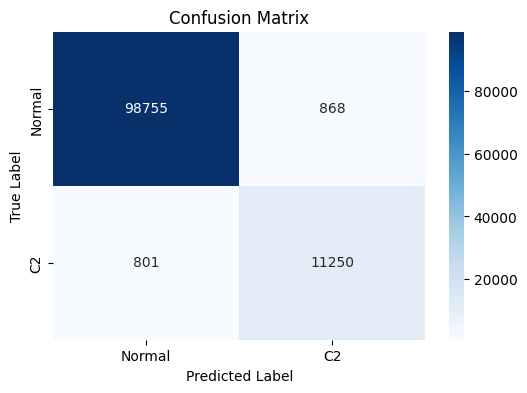

In [10]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "C2"], yticklabels=["Normal", "C2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [11]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     99623
           1       0.93      0.93      0.93     12051

    accuracy                           0.99    111674
   macro avg       0.96      0.96      0.96    111674
weighted avg       0.99      0.99      0.99    111674



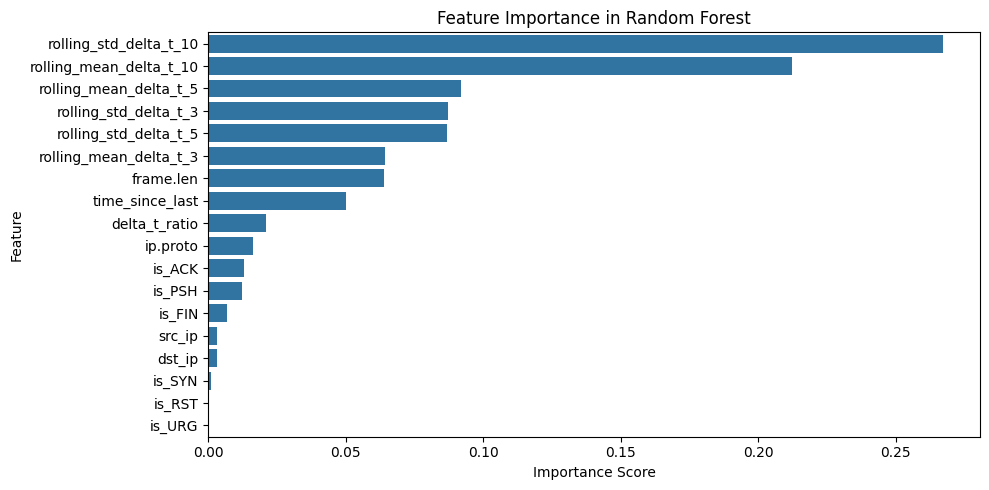

In [12]:
# Feature Importance (for Random Forest)
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.tight_layout()
plt.show()


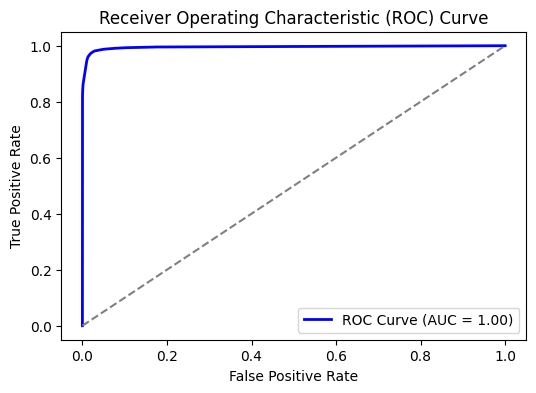

In [13]:
## ROC Curve and AUC Score
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

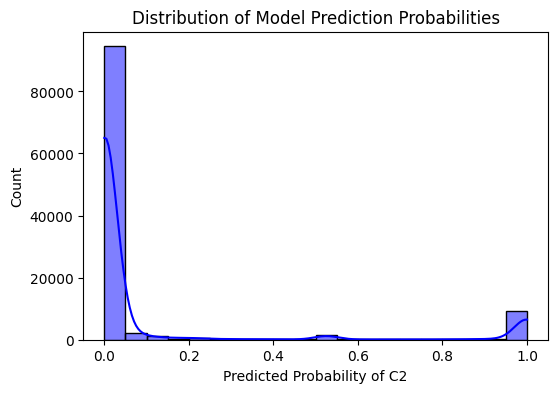

In [14]:
# Histogram of Predicted Probabilities
plt.figure(figsize=(6,4))
sns.histplot(model.predict_proba(X_test)[:, 1], bins=20, kde=True, color="blue")
plt.xlabel("Predicted Probability of C2")
plt.ylabel("Count")
plt.title("Distribution of Model Prediction Probabilities")
plt.show()


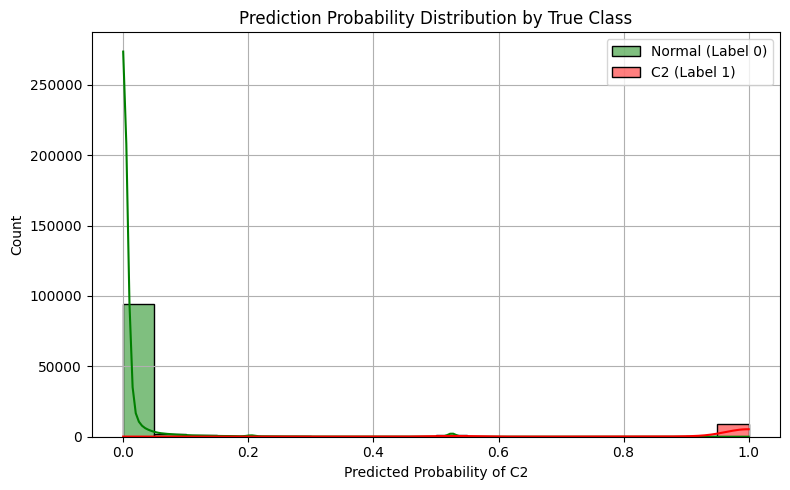

In [15]:
# Get prediction probabilities for the positive class (C2)
y_probs = model.predict_proba(X_test)[:, 1]

# Plot the distributions separately by true label
plt.figure(figsize=(8, 5))
sns.histplot(y_probs[y_test == 0], bins=20, kde=True, color="green", label="Normal (Label 0)", stat="count", alpha=0.5)
sns.histplot(y_probs[y_test == 1], bins=20, kde=True, color="red", label="C2 (Label 1)", stat="count", alpha=0.5)

plt.xlabel("Predicted Probability of C2")
plt.ylabel("Count")
plt.title("Prediction Probability Distribution by True Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Report Generation

Change the `Config` section to reflect each run

In [16]:
import os
from datetime import datetime
from collections import Counter

# === Config ===
DATASET_NAME = "combined_3"
NOTES = "Includes normal and c2 traffic. Random Forest Classification. 40% test split. Stratified sampling. Normalized features."
FRAMEWORKS = ["Metasploit", "Covenant", "Empire"]
EXPERIMENT_ID = f"{DATASET_NAME}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# === Directories ===
REPORT_DIR = "experiment_reports"
IMG_DIR = os.path.join(REPORT_DIR, "images")
os.makedirs(REPORT_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)

# === Class Counts ===
class_counts = Counter(y_test)
c2_ratio = round(class_counts[1] / sum(class_counts.values()), 4)

# === Save Plots ===

# 1. Pie Chart of Class Distribution
plt.figure(figsize=(5, 5))
labels = ["Normal", "C2"]
sizes = [class_counts[0], class_counts[1]]
colors = ["green", "red"]
explode = (0, 0.1)  # explode the C2 slice

def autopct_format(pct, all_vals):
    count = int(round(pct/100. * sum(all_vals)))
    return f"{pct:.1f}%\n({count})"

plt.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: autopct_format(pct, sizes),
    startangle=90,
    colors=colors,
    explode=explode,
    textprops={"fontsize": 10}
)
plt.title("Class Distribution in Test Set")
pie_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_pie.png")
plt.savefig(pie_path)
plt.close()



# 2. Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "C2"], yticklabels=["Normal", "C2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
conf_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_confusion.png")
plt.savefig(conf_path)
plt.close()

# 3. Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Classification")
feat_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_feature_importance.png")
plt.tight_layout()
plt.savefig(feat_path)
plt.close()

# 4. ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
roc_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_roc.png")
plt.savefig(roc_path)
plt.close()

# 5. Prediction Probabilities by Class
plt.figure(figsize=(8, 5))
sns.histplot(y_probs[y_test == 0], bins=20, kde=True, color="green", label="Normal (Label 0)", stat="count", alpha=0.5)
sns.histplot(y_probs[y_test == 1], bins=20, kde=True, color="red", label="C2 (Label 1)", stat="count", alpha=0.5)
plt.xlabel("Predicted Probability of C2")
plt.ylabel("Count")
plt.title("Prediction Probability Distribution by True Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
hist_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_hist.png")
plt.savefig(hist_path)
plt.close()

# === Write Report ===
report_path = os.path.join(REPORT_DIR, f"{EXPERIMENT_ID}.md")
with open(report_path, "w") as f:
    f.write(f"# Experiment Report: {DATASET_NAME}\n\n")
    f.write(f"- **Experiment ID:** {EXPERIMENT_ID}\n")
    f.write(f"- **Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"- **Frameworks:** {', '.join(FRAMEWORKS)}\n")
    # f.write(f"- **C2 Ratio (Test Set):** {c2_ratio}\n")
    # f.write(f"- **Total Samples (Test):** {sum(class_counts.values())} (Normal: {class_counts[0]}, C2: {class_counts[1]})\n\n")

    f.write("## Notes\n")
    f.write(f"{NOTES}\n\n")

    f.write("## Test Set Class Distribution\n")
    f.write(f"![Class Distribution Pie Chart](images/{os.path.basename(pie_path)})\n\n")


    f.write("## Confusion Matrix\n")
    f.write(f"![Confusion Matrix](images/{os.path.basename(conf_path)})\n\n")

    f.write("## Classification Report\n")
    f.write("```\n")
    f.write(classification_report(y_test, y_pred))
    f.write("```\n\n")

    f.write("## ROC Curve\n")
    f.write(f"![ROC Curve](images/{os.path.basename(roc_path)})\n\n")

    f.write("## Feature Importance\n")
    f.write(f"![Feature Importance](images/{os.path.basename(feat_path)})\n\n")

    f.write("## Prediction Probability Distribution by True Class\n")
    f.write(f"![Prediction Histogram](images/{os.path.basename(hist_path)})\n")

print(f"Markdown report saved: {report_path}")


Markdown report saved: experiment_reports\combined_3_2025-04-02_17-27-27.md
